#                                             Homework 3

## Maria Petrosyan

### Data Processing 

In [1]:
import pandas as pd
from lifelines import WeibullAFTFitter, LogNormalAFTFitter, LogLogisticAFTFitter, GeneralizedGammaFitter, ExponentialFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import pickle
import numpy as np
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('telco.csv')

print(data.head())
print(data.describe())
print(data.info())


   ID  region  tenure  age    marital  address  income  \
0   1  Zone 2      13   44    Married        9      64   
1   2  Zone 3      11   33    Married        7     136   
2   3  Zone 3      68   52    Married       24     116   
3   4  Zone 2      33   33  Unmarried       12      33   
4   5  Zone 2      23   30    Married        9      30   

                             ed retire  gender voice internet forward  \
0                College degree     No    Male    No       No     Yes   
1     Post-undergraduate degree     No    Male   Yes       No     Yes   
2  Did not complete high school     No  Female    No       No      No   
3            High school degree     No  Female    No       No      No   
4  Did not complete high school     No    Male    No       No     Yes   

         custcat churn  
0  Basic service   Yes  
1  Total service   Yes  
2   Plus service    No  
3  Basic service   Yes  
4   Plus service    No  
                ID       tenure          age      address     

In [4]:
# Check for missing values
print(data.isnull().sum())


ID          0
region      0
tenure      0
age         0
marital     0
address     0
income      0
ed          0
retire      0
gender      0
voice       0
internet    0
forward     0
custcat     0
churn       0
dtype: int64


In [5]:
def modify_data(input_data):
    processed_data = input_data.copy()
    processed_data = processed_data.set_index('ID') 

    # Convert categorical variables into numerical using label encoding
    categorical_cols = ['region', 'retire', 'marital', 'ed', 'gender', 'voice', 'internet', 'custcat', 'churn', 'forward']
    for col in categorical_cols:
        processed_data[col] = pd.factorize(processed_data[col])[0]

    return processed_data

In [6]:
data_encoded = modify_data(data)
data_encoded

,region,tenure,age,marital,address,income,ed,retire,gender,voice,internet,forward,custcat,churn
ID,,,,,,,,,,,,,,
1,0,13,44,0,9,64,0,0,0,0,0,0,0,0
2,1,11,33,0,7,136,1,0,0,1,0,0,1,0
3,1,68,52,0,24,116,2,0,1,0,0,1,2,1
4,0,33,33,1,12,33,3,0,1,0,0,1,0,0
5,0,23,30,0,9,30,2,0,0,0,0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,1,10,39,1,0,27,4,0,1,0,0,1,0,1
997,2,7,34,1,2,22,1,0,1,0,0,1,0,1
998,1,67,59,1,40,944,1,0,1,1,1,0,1,1


### Parametric Models

In [7]:
# Initialize the models
aft_models = {
    "Weibull": WeibullAFTFitter(),
    "LogNormal": LogNormalAFTFitter(),
    "LogLogistic": LogLogisticAFTFitter(),
    "GeneralizedGamma": GeneralizedGammaFitter(),
    "Exponential": ExponentialFitter()
}

In [8]:
# Fit the models
for model_name, model in aft_models.items():
    try:
        if model_name in ["GeneralizedGamma", "Exponential"]:
            model.fit(data_encoded['tenure'], data_encoded['churn'])
        else:
            model.fit(data_encoded, 'tenure', 'churn')
        print(f"{model_name} AFT Model Fitted.")
    except Exception as e:
        print(f"Error fitting {model_name}: {e}")
        
for model_name, model in aft_models.items():
    try:
        with open(f"{model_name}_aft_model.pkl", 'wb') as f:
            pickle.dump(model, f)
        print(f"{model_name} model saved.")
    except Exception as e:
        print(f"Error saving {model_name} model: {e}")

Weibull AFT Model Fitted.
LogNormal AFT Model Fitted.
LogLogistic AFT Model Fitted.
GeneralizedGamma AFT Model Fitted.
Exponential AFT Model Fitted.
Weibull model saved.
LogNormal model saved.
LogLogistic model saved.
GeneralizedGamma model saved.
Exponential model saved.


In [9]:
for model_name, model in aft_models.items():
    try:
        # Use summary for model comparison
        print(f"{model_name} AFT Model Summary:")
        print(model.summary)
    except Exception as e:
        print(f"Error in summarizing {model_name}: {e}")

Weibull AFT Model Summary:
                       coef  exp(coef)  se(coef)  coef lower 95%  \
param   covariate                                                  
lambda_ address    0.009758   1.009805  0.002059        0.005722   
        age        0.007386   1.007413  0.001950        0.003564   
        custcat    0.110488   1.116823  0.014548        0.081974   
        ed        -0.000559   0.999441  0.011802       -0.023690   
        forward    0.019437   1.019627  0.034826       -0.048822   
        gender     0.010810   1.010869  0.031532       -0.050990   
        income     0.000248   1.000248  0.000182       -0.000108   
        internet   0.017990   1.018153  0.038558       -0.057583   
        marital   -0.117328   0.889294  0.031562       -0.179188   
        region    -0.016147   0.983983  0.019643       -0.054647   
        retire    -0.054926   0.946555  0.078306       -0.208403   
        voice      0.152509   1.164753  0.042872        0.068482   
        Intercept  3.

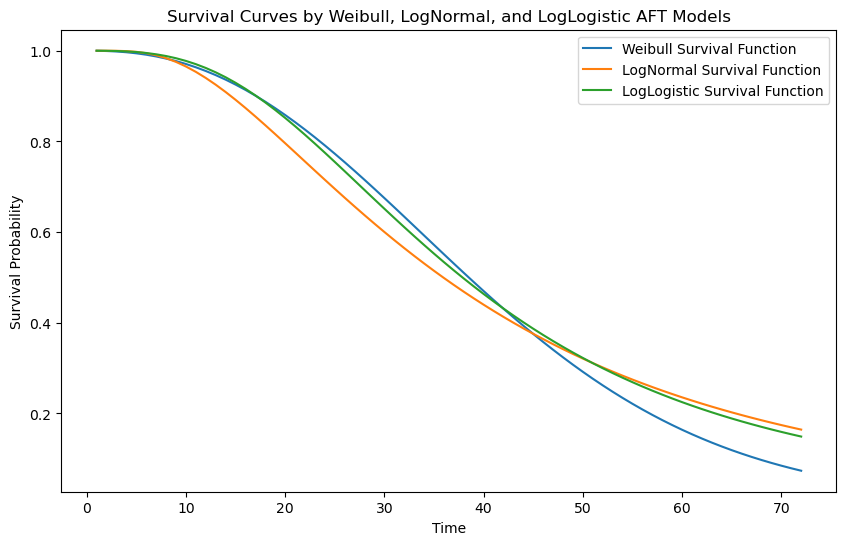

In [10]:
# Predicting median survival time for an Exponential distribution
if isinstance(model, ExponentialFitter):
    lambda_ = model.summary.loc['lambda_', 'coef']
    median_survival_time = np.log(2) / lambda_
    data_encoded['PredictedMedianLifetime'] = median_survival_time
else:
    data_encoded['PredictedMedianLifetime'] = model.predict_median(data_encoded)


plt.figure(figsize=(10, 6))


# Plot survival functions for Weibull, LogNormal, and LogLogistic models only
desired_models = ["Weibull", "LogNormal", "LogLogistic"]

for model_name, model in aft_models.items():
    try:
        if model_name in desired_models and hasattr(model, 'predict_survival_function'):
            sample = data_encoded.iloc[:10]  # Adjust as needed
            survival_function = model.predict_survival_function(sample)
            plt.plot(survival_function.mean(axis=1), label=f'{model_name} Survival Function')
    except Exception as e:
        print(f"Error in plotting for {model_name}: {e}")

plt.title('Survival Curves by Weibull, LogNormal, and LogLogistic AFT Models')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()

Initial Phase (Time 0 to 10):
All three models start with a survival probability close to 1, indicating that almost all subjects are 'surviving' or not experiencing the event (e.g., churn) at the beginning of the observation period.

Middle Phase (Time 10 to 40):
The Weibul and Log-Logistic models show very similar survival probabilities, closely following each other.
The Log_Normal model diverges slightly from the other two, generally indicating a slightly lower survival probability across this range. This suggests it estimates a faster rate of decay in survival probability.

Later Phase (Time 40 to 70):
The Weibull model starts to diverge downward more steeply than the Log-Logistic model.
The Log-Normal model shows the highest survival probability, although the differences among the models is not huge, the Log-Normal showing the slowest decline in survival probability.

With Log-Normal model showing the highest survival probability in the end of the Time, we will proceed with this model.

### CLV

In [11]:
# List of columns considered significant
important_columns = ["address", "age", "internet", "marital", "tenure", "churn",
                       "custcat", "custcat", "voice"]

important_data = data_encoded[important_columns]

In [12]:
# Fit the Log-Normal model
log_norm = aft_models["LogNormal"].fit(data_encoded, duration_col='tenure', event_col='churn')
log_norm_prediction = log_norm.predict_survival_function(data_encoded).T
log_norm_prediction_avg = log_norm_prediction.mean()
log_norm.print_summary()

<lifelines.LogNormalAFTFitter: fitted with 1000 total observations, 274 right-censored observations>
             duration col = 'tenure'
                event col = 'churn'
   number of observations = 1000
number of events observed = 726
           log-likelihood = -3362.23
         time fit was run = 2024-04-30 20:26:44 UTC

---
                                 coef  exp(coef)    se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                        
mu_    PredictedMedianLifetime   1.32       3.75 64886744.32    -127175680.62     127175683.27                 0.00                  inf
       address                   0.02       1.02        0.00             0.01             0.02                 1.01                 1.02
       age                       0.01       1.01        0.00             0.01             0.02                 1.01                 1.02
       custcat                   0.16       1.18        0.02             0.12             0.21                 1.13                 1.23
       ed                       -0.01       0.99        0.02            -0.04             0.03                 0.96                 1.03
       forward                   0.04       1.04        0.05            -0.06             0.14                 0.94                 1.15
       gender                    0.01       1.01        0.05            -0.08             0.10                 0.93                 1.11
       income                    0.00       1.00        0.00            -0.00             0.00                 1.00                 1.00
       internet                  0.04       1.05        0.05            -0.06             0.15                 0.94                 1.16
       marital                  -0.21       0.81        0.05            -0.30            -0.12                 0.74                 0.89
       region                   -0.03       0.97        0.03            -0.08             0.03                 0.92                 1.03
       retire                   -0.19       0.82        0.12            -0.42             0.03                 0.66                 1.03
       voice                     0.19       1.20        0.06             0.07             0.30                 1.07                 1.35
       Intercept                 2.67      14.39   919118.98      -1801437.42       1801442.76                 0.00                  inf
sigma_ Intercept                -0.43       0.65        0.03            -0.48            -0.38                 0.62                 0.68

                                 cmp to      z      p   -log2(p)
param  covariate                                                
mu_    PredictedMedianLifetime     0.00   0.00   1.00       0.00
       address                     0.00   5.93 <0.005      28.26
       age                         0.00   4.26 <0.005      15.55
       custcat                     0.00   7.79 <0.005      47.12
       ed                          0.00  -0.31   0.76       0.40
       forward                     0.00   0.80   0.42       1.24
       gender                      0.00   0.28   0.78       0.36
       income                      0.00   1.27   0.20       2.29
       internet                    0.00   0.83   0.41       1.30
       marital                     0.00  -4.62 <0.005      18.00
       region                      0.00  -1.06   0.29       1.78
       retire                      0.00  -1.68   0.09       3.41
       voice                       0.00   3.15 <0.005       9.27
       Intercept                   0.00   0.00   1.00       0.00
sigma_ Intercept                   0.00 -16.57 <0.005     202.48
---
Concordance = 0.71
AIC = 6754.47
log-likelihood ratio test = 232.01 on 13 df
-log2(p) of ll-ratio test = 137.74

In [13]:
# Creating a copy of Log-Normal model predictions for Customer Lifetime Value (CLV) calculation
clv_predictions = log_norm_prediction.copy()

# Setting up parameters for CLV calculation
margin_per_month = 1000 
months_sequence = range(1, len(clv_predictions.columns) + 1)  
discount_rate = 0.1  

# Adjusting the CLV data based on the discount rate
for month in months_sequence:
    clv_predictions.loc[:, month] = clv_predictions.loc[:, month] / ((1 + discount_rate / 12) ** (months_sequence[month - 1] - 1))
    
# Calculating CLV for each customer
clv_predictions["CLV"] = margin_per_month * clv_predictions.sum(axis=1)
clv_predictions

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,64.0,65.0,66.0,67.0,68.0,69.0,70.0,71.0,72.0,CLV
ID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.991715,0.983286,0.974218,0.963856,0.951613,0.937093,0.920129,0.900748,0.879124,...,0.063851,0.060762,0.057833,0.055054,0.052417,0.049915,0.047541,0.045287,0.043148,27672.499442
2,1.000000,0.991729,0.983451,0.974947,0.965865,0.955824,0.944491,0.931636,0.917139,0.900984,...,0.099233,0.094937,0.090837,0.086922,0.083186,0.079618,0.076213,0.072961,0.069855,31398.909728
3,1.000000,0.991735,0.983537,0.975392,0.967271,0.959125,0.950885,0.942479,0.933828,0.924862,...,0.260362,0.252687,0.245227,0.237978,0.230935,0.224093,0.217448,0.210994,0.204728,42168.919318
4,0.999999,0.991630,0.982521,0.971332,0.956796,0.938183,0.915355,0.888624,0.858572,0.825906,...,0.030451,0.028749,0.027150,0.025646,0.024232,0.022902,0.021651,0.020474,0.019365,22660.323568
5,1.000000,0.991728,0.983436,0.974876,0.965661,0.955379,0.943684,0.930347,0.915260,0.898425,...,0.093410,0.089298,0.085377,0.081637,0.078070,0.074668,0.071422,0.068326,0.065372,30849.354727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0.999997,0.991442,0.981107,0.966680,0.946570,0.920372,0.888604,0.852296,0.812665,0.770901,...,0.016979,0.015940,0.014970,0.014064,0.013217,0.012426,0.011686,0.010993,0.010345,19552.178056
997,0.999996,0.991372,0.980630,0.965208,0.943497,0.915243,0.881177,0.842527,0.800664,0.756884,...,0.014840,0.013916,0.013053,0.012249,0.011498,0.010796,0.010142,0.009530,0.008958,18920.708440
998,1.000000,0.991736,0.983539,0.975410,0.967344,0.959337,0.951377,0.943451,0.935542,0.927630,...,0.404251,0.395875,0.387634,0.379528,0.371557,0.363721,0.356020,0.348453,0.341021,48496.261619


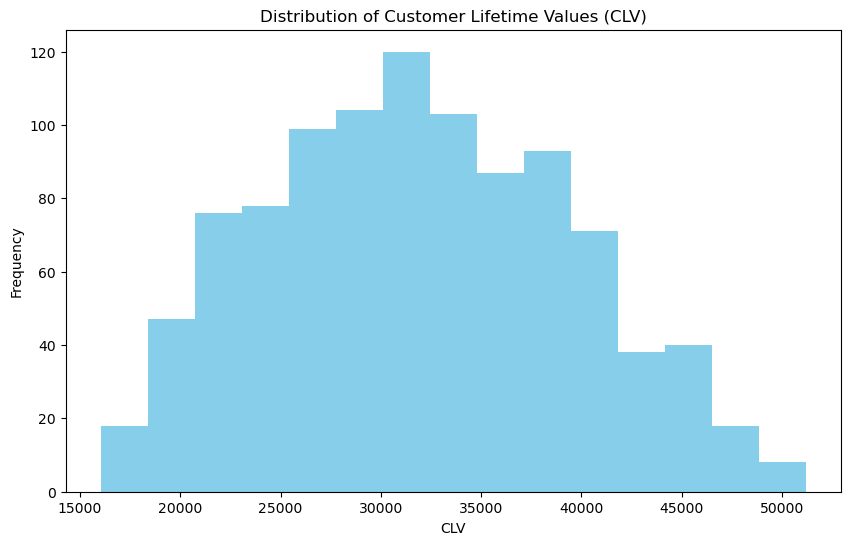

In [15]:
# Histogram of CLV values
plt.figure(figsize=(10, 6))
plt.hist(clv_predictions['CLV'], bins=15, color='skyblue')
plt.xlabel('CLV')
plt.ylabel('Frequency')
plt.title('Distribution of Customer Lifetime Values (CLV)')
plt.show()

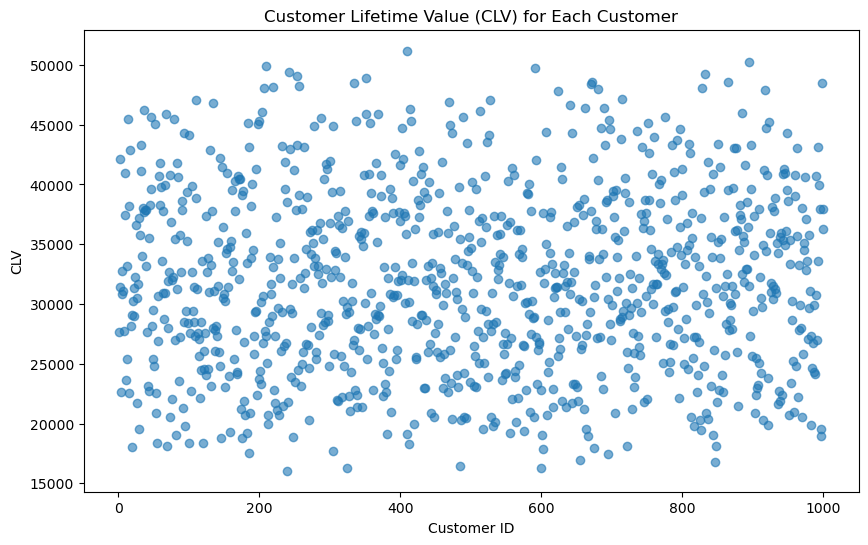

In [18]:
# Scatter Plot for individual CLV visualization
plt.figure(figsize=(10, 6))
plt.scatter(clv_predictions.index, clv_predictions['CLV'], alpha=0.6)
plt.title('Customer Lifetime Value (CLV) for Each Customer')
plt.xlabel('Customer ID')
plt.ylabel('CLV')
plt.show()

In [20]:
data["CLV"] = clv_predictions.CLV

# Analyzing CLV based on different groupings.
print(data.groupby(["gender", "ed", "marital"])[["CLV"]].mean())
print(data.groupby("gender")[["CLV"]].mean())
print(data.groupby("voice")[["CLV"]].mean())
print(data.groupby("forward")[["CLV"]].mean())
print(data.groupby("internet")[["CLV"]].mean())
print(data.groupby("marital")[["CLV"]].mean())
print(data.groupby("region")[["CLV"]].mean())
print(data.groupby("custcat")[["CLV"]].mean())
print(data.groupby("retire")[["CLV"]].mean())
print(data.groupby("ed")[["CLV"]].mean())

                                                        CLV
gender ed                           marital                
Female College degree               Married    32368.384749
                                    Unmarried  31415.234395
       Did not complete high school Married    33355.807950
                                    Unmarried  31365.061013
       High school degree           Married    31151.433514
                                    Unmarried  31687.981872
       Post-undergraduate degree    Married    30529.175417
                                    Unmarried  28134.716676
       Some college                 Married    32153.150162
                                    Unmarried  32866.482340
Male   College degree               Married    32296.681182
                                    Unmarried  31636.503281
       Did not complete high school Married    31893.188027
                                    Unmarried  32237.947715
       High school degree           Marr

My analysis of Customer Lifetime Value (CLV) across various demographics and service types has revealed significant insights that can guide targeted marketing and customer retention strategies.

1. Demographic Insights

Gender and Education:
Females with a high school degree or less tend to show higher CLVs compared to those with higher education levels, particularly when married. For instance, married females without a high school diploma exhibit a CLV of approximately $33,356, the highest among female groups.
Males show a less pronounced difference across education levels, but those with a high school degree or some college education, particularly when married, tend to have higher CLVs, suggesting that stability and moderate educational attainment correlate with higher value.

Marital Status:
Married customers consistently show higher CLVs across both genders and various education levels compared to their unmarried counterparts. This suggests that married individuals may have more stable and predictable purchasing behaviors, making them valuable targets for long-term customer engagement strategies.

2. Service Usage Insights

Internet and Forwarding Services:
Customers without internet services tend to have a higher CLV ($32,150) compared to those with internet services ($31,566). This could indicate a potential area to improve service offerings or customer support for internet users.
Those who use call forwarding services exhibit higher CLVs ($32,259) than those who do not ($31,620), highlighting the value of this feature in retaining high-value customers.

Voice Services:
There is a slight differentiation in CLV based on voice service usage, with non-users marginally outvaluing users. This might reflect differing usage patterns or satisfaction levels with voice service features.

3. Regional and Category-Based Insights:

Regional Variations:
CLV varies slightly by region, with Zone 1 showing the highest average CLV at $32,178, followed by Zone 2 and Zone 3. Targeted regional marketing strategies can be tailored to leverage these variations.

Customer Categories:
Customers classified under 'Basic service' and 'Plus service' categories show similar CLVs, both slightly higher than those in 'E-service' and 'Total service'. This may suggest a reevaluation of service packages and pricing strategies to enhance the perceived value of 'E-service' and 'Total service' categories.

4. Influence of Retirement:

Retired customers show significantly higher CLVs at $32,980 compared  to  non  retired at $31,883.  This indicates the effectiveness of tailored marketing strategies for retirees, possibly due to their higher disposable income or different service needs.

### Budget Calculation

In [23]:
# Filter retained customers
data_encoded["CLV"] = clv_predictions.CLV
retained_customers = data_encoded["CLV"][data_encoded['churn'] == 0]
# Calculate retained CLV
retained_clv = retained_customers.sum()

# Define retention rate and cost per customer
retention_rate = 0.8  # Assuming 80% retention rate
cost_per_customer = 5000  # Assuming $5000 cost per customer

# Calculate retention cost and annual budget
retention_cost = len(data_encoded) * retention_rate * cost_per_customer
annual_budget = retained_clv - retention_cost

print("RETAINED CLV:", retained_clv)
print("RETENTION COST:", retention_cost)
print("ANNUAL BUDGET:", annual_budget)

RETAINED CLV: 8075966.184994456
RETENTION COST: 4000000.0
ANNUAL BUDGET: 4075966.1849944564


### Report

In this detailed analysis of customer behavior and churn risk, Ive discovered that demographic factors such as age, marital status, education level, and service-related variables including internet quality and additional service features significantly impact Customer Lifetime Value (CLV) and churn probability. The survival analysis models indicate that positive coefficients enhance customer retention, improving CLV, while negative coefficients reduce retention duration. Notably, married individuals, especially those with basic or no college education, and retired customers demonstrate higher CLVs, attributed to their life stability and consistent usage patterns. This study reveals an annual retention budget surplus of approximately $4.08 million, calculated from a retained CLV of about $8.1 million after accounting for a $4 million retention cost, suggesting effective existing customer engagement strategies.

To further enhance retention, I recommend focusing on high-value segments identified through personalized retention strategies tailored to their needs. Enhancing customer support, particularly for internet service users, and implementing personalized marketing and loyalty programs for long-term customers can significantly reduce churn. 